## Histogram-based Outlier Score (HBOS)
* Type: Unsupervised Distribution-Based
* Idea: If a value falls in the tail of a histogram, it means that the value deviates from most of other values and is likely and outlier.
* It defines Univariate Outlier Score for each variable. 
* Independence assumption, allow to make the scores additive.
* It constructs a histogram for each feature. The univariate score is calculated like:
- - HBOS (p) = Sum_{N,i=1} of ( log( 1 / hist_i( p )))
* Where:
* hist_i( p ) is the height of the variable i, for the observation p.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

### Create a data set with 5% of outliers.

In [3]:
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


* Plot the first 2 variables, can we already see the outliers?

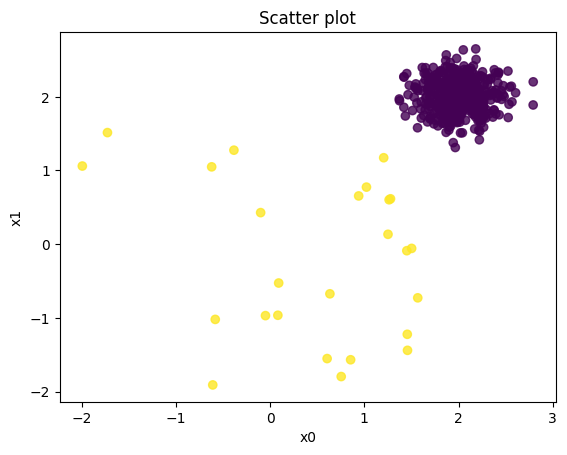

In [4]:
def plot_data():
    # Plot
    plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()
plot_data()

### Build the model
* An important hyperparameter is *Number of Bins*.
- - This parameter will cluster or split several instances. We should try different values and get the average outlier scores that the models output.

In [5]:
from pyod.models.hbos import HBOS

n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

#### Run the model
* By sorting the instances based on their HBScore, the first X% ( in this case 5% ) will be the observation with the higher *outlier-ness*.

In [7]:
# Training data
# y_train_scores contains the HBScores per observation.
y_train_scores = hbos.decision_function(X_train)

# hbos.predict, sets a binary label to the observations.
# if the HBScore of the obs is higher than the threhsold ( 5% ), becomes a 1.
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

#### Let's check how the model performed

In [12]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate is:" , hbos.threshold_)
print("The training data:", count_stat(y_train_pred))
print("The testing data:", count_stat(y_test_pred))

The threshold for the defined contamination rate is: 5.563712646460526
The training data: {0: 475, 1: 25}
The testing data: {0: 474, 1: 26}


### Determine the threshold
* We will probably not know the percentage of outliers in the real world.
* However, the HBScore already measures the deviation of a data point from others. Hence, we can sort the data by their outlier.

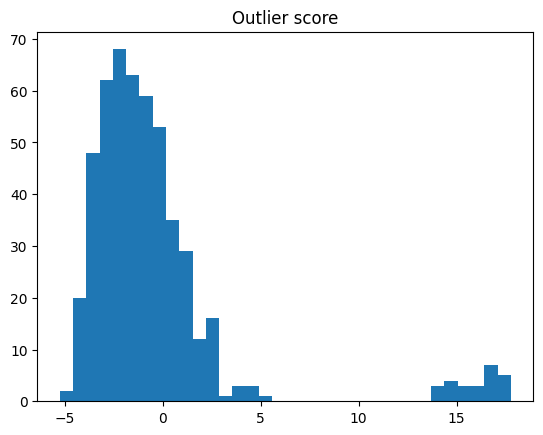

In [13]:
import matplotlib.pyplot as plt

plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

As we can see, the model already seems to create a threshold at 5.5. 

### Descriptive statistics
* In order to check the soundness of the model, the statistical table must make sense.
* The characteristics of the outliers should be significantly different from the normal ones.
* We can proove this with the Descriptive Statistical Table

In [14]:
threshold = hbos.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Convert the training set into a pandas data frame.
    df = pd.DataFrame(df)

    # Add the HBScore Column.
    df['Anomaly_Score'] = pred_score
    
    # Add the Target value depending on the threshold.
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-1.28
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,16.02


In [15]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,474,94.8,2.02,2.01,2.01,1.99,2.01,2.00,-1.05
1,Outlier,26,5.2,0.06,-0.43,-0.12,0.02,0.02,0.18,16.65


### Since we have the ground truth data, we can perform a Confussion Matrix
* We obtained 25 outliers.

In [17]:
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [18]:
confusion_matrix(y_test,y_test_scores,threshold)

Pred,0,1
Actual,,
0.0,474,1
1.0,0,25


### Aggregate Model Predictions to Achieve Stability
1. Standarize the input data in case the features do not share the same scale.
2. Play with different hyperparameters: Number of bins.
3. Store predicted scores per model.
4. Aggregate results to balance for overfitting or other model issues.
*
* HBOS can be sensitive to the bin width of the histogram. If the bins are too narrow, the normal data points falling in these bins will be identified as outliers. 
* If bins are too wide, outliers would fall into normal bins.
* Solution:
* Build HBOS models with a range of histogram widths to obtain multiple scores and then AGGREGATE the scores.
* It reduces the chance of overfitting and increase prediction accuracy.
* There are different methods to aggregate the HBScores:
- - Average
- - Maximum of Maximum ( MOM )
- - Average of Maximum ( AOM )
- - Maximum of Average ( MOA )

In [21]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS

# Standardize data to avoid problems when aggregating
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of different BINS:
k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]

# Number of models == length( k_list )
n_clf = len(k_list)

# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_norm) 
    test_scores[:, i] = hbos.decision_function(X_test_norm) 

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

### Combination by average

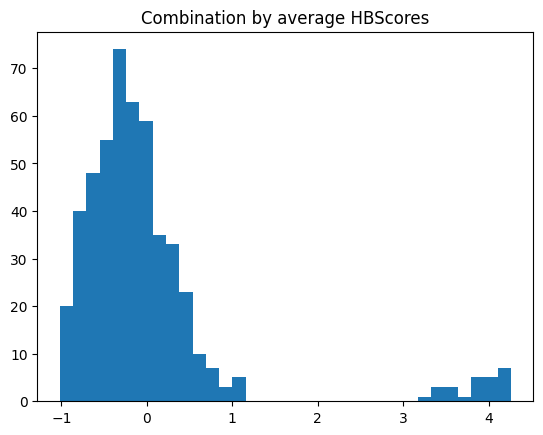

In [29]:
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average HBScores")
plt.show()

* This plot shows the aggregated by average HBScoresof the different models with different Bin Sizes.
* As we can see, the histogram suggest a threshold of 1.4.

In [30]:
# Descriptive statistics with a 1.4 Threshold:
descriptive_stat_threshold(X_train,y_train_by_average, 1.4)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.20
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,3.86


### Rank the observations based on their MULTIVARIATE HBSCORE

In [42]:
y_train_by_average_pd = pd.DataFrame(y_train_by_average, columns=["HBScores"]).sort_values(by="HBScores", ascending=False)

In [45]:
y_train_by_average_pd.head()

,HBScores
499,4.258054
477,4.235000
496,4.218357
480,4.151176
492,4.137475


## Summary
* HBOS defines the univariate outlier scre based on the hisogram value.
* It assumes independence variable distribution.
* The univariate score can be added up to get the Multivariate outlier score for an instance.
* Efficient unsupervised method to detect anomalies with high explainability.